In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Feature extraction

import time

import numpy as np
import pandas as pd
import re

# For convenient vectorized calculations of haversine distance
from haversine import haversine, haversine_vector

# Show progress bar
from tqdm import tqdm

class FeatureExtraction:    
    # Modified to fit the Kaggle input
    KAGGLE_INPUT = "/kaggle/input/inputdata/"
    
    TRAIN_DATA = KAGGLE_INPUT + "train_featureextraction_output.csv"
    TEST_DATA = KAGGLE_INPUT + "test_featureextraction_output.csv"

    TRAIN_DATA_OUTPUT = "train_featureextraction_output.csv"
    TEST_DATA_OUTPUT = "test_featureextraction_output.csv"

    AUXILLARY_COMMERCIAL_CENTRES = KAGGLE_INPUT + "auxiliary-data/sg-commerical-centres.csv"
    AUXILLARY_MARKETS_HAWKER_CENTRES = KAGGLE_INPUT + "auxiliary-data/sg-gov-markets-hawker-centres.csv"
    AUXILLARY_POPULATION_DEMOGRAPHICS = KAGGLE_INPUT + "auxiliary-data/sg-population-demographics.csv"
    AUXILLARY_PRIMARY_SCHOOLS = KAGGLE_INPUT + "auxiliary-data/sg-primary-schools.csv"
    AUXILLARY_SECONDARY_SCHOOLS = KAGGLE_INPUT + "auxiliary-data/sg-secondary-schools.csv"
    AUXILLARY_SHOPPING_MALLS = KAGGLE_INPUT + "auxiliary-data/sg-shopping-malls.csv"
    AUXILLARY_TRAIN_STATIONS = KAGGLE_INPUT + "auxiliary-data/sg-train-stations.csv"
    
    CPI = KAGGLE_INPUT + 'cpi_processed.csv'
    
    CBD_LATITUDE = 1.291667
    CBD_LONGITUDE = 103.85
    
    RADIUS_TOLERANCE = 1  # 1km radius

    def run(self):
        start_time = time.time()

        # Load data
        print("Loading data...")

        (train_data, test_data) = self.load_train_test_data()
        self.load_auxillary_data()

        # Comment out when calculating on actual data (takes a sample for testing purposes)
        # train_data = train_data.sample(n=200, random_state=42)
        # test_data = test_data.sample(n=200, random_state=42)

        # Add features to training data
        print("Adding additional features to training data...")
        train_data_new = self.add_features(train_data)

        # Add features to test data
        print("Adding additional features to test data...")
        test_data_new = self.add_features(test_data)

        # Save data to csv
        print("Saving data...")
        train_data_new.to_csv(self.TRAIN_DATA_OUTPUT, index=False)
        test_data_new.to_csv(self.TEST_DATA_OUTPUT, index=False)

        # Done
        end_time = time.time()
        print(f"Completed feature extraction in {(end_time - start_time):.3f} seconds")

    def add_features(self, data):
        dist_closest_market_hawker_centre = self.get_dist_closest_market_hawker_centre(data)
        data['dist_closest_market_hawker_centre'] = dist_closest_market_hawker_centre

        num_market_hawker_centre = self.get_num_market_hawker_centres_within_radius(data)
        data['num_market_hawker_centre_within_radius'] = num_market_hawker_centre

        dist_closest_primary_school = self.get_dist_closest_primary_school(data)
        data['dist_closest_primary_school'] = dist_closest_primary_school

        num_primary_schools = self.get_num_primary_schools_within_radius(data)
        data['num_primary_schools_within_radius'] = num_primary_schools

        dist_closest_secondary_school = self.get_dist_closest_secondary_school(data)
        data['dist_closest_secondary_school'] = dist_closest_secondary_school

        num_secondary_schools = self.get_num_secondary_schools_within_radius(data)
        data['num_secondary_schools_within_radius'] = num_secondary_schools

        dist_closest_shopping_mall = self.get_dist_closest_shopping_mall(data)
        data['dist_closest_shopping_mall'] = dist_closest_shopping_mall

        num_shopping_malls = self.get_num_shopping_malls_within_radius(data)
        data['num_shopping_malls_within_radius'] = num_shopping_malls

        dist_closest_train_station = self.get_dist_closest_train_station(data)
        data['dist_closest_train_station'] = dist_closest_train_station

        num_train_stations = self.get_num_train_stations_within_radius(data)
        data['num_train_stations_within_radius'] = num_train_stations
        
        dist_to_cbd = self.get_dist_to_cbd(data)
        data['dist_to_cbd'] = dist_to_cbd

        (year, month) = self.get_month_and_year(data)
        data['year'] = year
        data['month'] = month

        (street_number_is_8, street_number_is_13, street_number_is_4) = self.get_inauspicious_street_number(data)
        data['street_number_is_8'] = street_number_is_8
        data['street_number_is_13'] = street_number_is_13
        data['street_number_is_4'] = street_number_is_4
        
        (block_number_is_8, block_number_is_13, block_number_is_4) = self.get_inauspicious_block_number(data)
        data['block_number_is_8'] = block_number_is_8
        data['block_number_is_13'] = block_number_is_13
        data['block_number_is_4'] = block_number_is_4

        letters = self.get_block_letter(data)
        data['block_letter'] = letters

        data['age_of_lease'] = self.get_age_of_lease(data)
        
        cpi = self.deflate_resale_price(data)
        data['cpi'] = cpi

        return data.sort_index(axis=1)

    def load_train_test_data(self):
        train_data = pd.read_csv(self.TRAIN_DATA)
        test_data = pd.read_csv(self.TEST_DATA)
        return (train_data, test_data)

    def load_auxillary_data(self):
        self.commercial_centres = pd.read_csv(
            self.AUXILLARY_COMMERCIAL_CENTRES)
        self.markets_hawker_centres = pd.read_csv(
            self.AUXILLARY_MARKETS_HAWKER_CENTRES)
        self.population_demographics = pd.read_csv(
            self.AUXILLARY_POPULATION_DEMOGRAPHICS)
        self.primary_schools = pd.read_csv(self.AUXILLARY_PRIMARY_SCHOOLS)
        self.secondary_schools = pd.read_csv(self.AUXILLARY_SECONDARY_SCHOOLS)
        self.shopping_malls = pd.read_csv(self.AUXILLARY_SHOPPING_MALLS)
        self.train_stations = pd.read_csv(self.AUXILLARY_TRAIN_STATIONS)

    def get_dist_closest_market_hawker_centre(self, data):
        market_hawker_centre_vector = self.markets_hawker_centres[['lat', 'lng']]

        def dist_closest_market_hawker_centre(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.markets_hawker_centres), 1))

            distance = haversine_vector(latlng_vector, market_hawker_centre_vector)
            return np.amin(distance)

        return data.progress_apply(dist_closest_market_hawker_centre, axis=1)

    def get_num_market_hawker_centres_within_radius(self, data):
        market_hawker_centre_vector = self.markets_hawker_centres[['lat', 'lng']]

        def num_market_hawker_centre_within_radius(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.markets_hawker_centres), 1))

            distance = haversine_vector(latlng_vector, market_hawker_centre_vector)
            return (distance <= self.RADIUS_TOLERANCE).sum()

        return data.progress_apply(num_market_hawker_centre_within_radius, axis=1)

    def get_dist_closest_primary_school(self, data):
        primary_schools_vector = self.primary_schools[['lat', 'lng']]

        def dist_closest_primary_school(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.primary_schools), 1))

            distance = haversine_vector(latlng_vector, primary_schools_vector)
            return np.amin(distance)

        return data.progress_apply(dist_closest_primary_school, axis=1)

    def get_num_primary_schools_within_radius(self, data):
        primary_schools_vector = self.primary_schools[['lat', 'lng']]

        def num_primary_schools_within_radius(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.primary_schools), 1))

            distance = haversine_vector(latlng_vector, primary_schools_vector)
            return (distance <= self.RADIUS_TOLERANCE).sum()

        return data.progress_apply(num_primary_schools_within_radius, axis=1)

    def get_dist_closest_secondary_school(self, data):
        secondary_schools_vector = self.secondary_schools[['lat', 'lng']]

        def dist_closest_secondary_school(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.secondary_schools), 1))

            distance = haversine_vector(latlng_vector, secondary_schools_vector)
            return np.amin(distance)

        return data.progress_apply(dist_closest_secondary_school, axis=1)

    def get_num_secondary_schools_within_radius(self, data):
        secondary_schools_vector = self.secondary_schools[['lat', 'lng']]

        def num_secondary_schools_within_radius(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.secondary_schools), 1))

            distance = haversine_vector(latlng_vector, secondary_schools_vector)
            return (distance <= self.RADIUS_TOLERANCE).sum()

        return data.progress_apply(num_secondary_schools_within_radius, axis=1)

    def get_dist_closest_shopping_mall(self, data):
        shopping_malls_vector = self.shopping_malls[['lat', 'lng']]

        def dist_closest_shopping_mall(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.shopping_malls), 1))

            distance = haversine_vector(latlng_vector, shopping_malls_vector)
            return np.amin(distance)

        return data.progress_apply(dist_closest_shopping_mall, axis=1)

    def get_num_shopping_malls_within_radius(self, data):
        shopping_malls_vector = self.shopping_malls[['lat', 'lng']]

        def num_shopping_malls_within_radius(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.shopping_malls), 1))

            distance = haversine_vector(latlng_vector, shopping_malls_vector)
            return (distance <= self.RADIUS_TOLERANCE).sum()

        return data.progress_apply(num_shopping_malls_within_radius, axis=1)

    def get_dist_closest_train_station(self, data):
        train_stations_vector = self.train_stations[['lat', 'lng']]

        def dist_closest_train_station(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.train_stations), 1))

            distance = haversine_vector(latlng_vector, train_stations_vector)
            return np.amin(distance)

        return data.progress_apply(dist_closest_train_station, axis=1)

    def get_num_train_stations_within_radius(self, data):
        train_stations_vector = self.train_stations[['lat', 'lng']]

        def num_train_stations_within_radius(row):
            latlng_vector = np.tile(tuple(row[['latitude', 'longitude']]),
                                    (len(self.train_stations), 1))

            distance = haversine_vector(latlng_vector, train_stations_vector)
            return (distance <= self.RADIUS_TOLERANCE).sum()

        return data.progress_apply(num_train_stations_within_radius, axis=1)
    
    def get_dist_to_cbd(self, data):
        def dist_to_cbd(row):
            distance = haversine((row['latitude'], row['longitude']), (self.CBD_LATITUDE, self.CBD_LONGITUDE))
            return distance

        return data.progress_apply(dist_to_cbd, axis=1)
    
    def get_month_and_year(self, data):
        monthlist = data['month'].to_list()

        year, month = [], []

        for l in monthlist:
            year.append(l.split('-')[0])
            month.append(l.split('-')[1])

        return year, month

    def get_inauspicious_street_number(self, data):
        is_8 = data['street_name'].str.contains('8', regex=True).astype(int)
        is_13 = data['street_name'].str.contains('13', regex=True).astype(int)
        is_4 = data['street_name'].str.contains('4', regex=True).astype(int)
            
        return is_8, is_13, is_4
    
    def get_inauspicious_block_number(self, data):
        is_8 = data['block'].str.contains('8', regex=True).astype(int)
        is_13 = data['block'].str.contains('13', regex=True).astype(int)
        is_4 = data['block'].str.contains('4', regex=True).astype(int)
        
        return is_8, is_13, is_4

    def get_age_of_lease(self, data):
        return data['year'].astype(int) - data['lease_commence_date'].astype(int)
          
    
    def get_block_letter(self, data):
        letters = data['block'].str.extract('([A-Za-z])', expand=False)

        # fill in 0 to street without numbers
        letters = letters.fillna(0).to_list()

        letters_new = [ord(letter.upper()) - 64 if letter != 0 else 0 for letter in letters]

        return letters_new
    
    def deflate_resale_price(self, data):
        cpi = pd.read_csv(self.CPI)
        
        data[['year', 'month']] = data[['year', 'month']].astype(int)
        
        cpi[['year', 'month']] = cpi[['year', 'month']].astype(int)
        
        merge = data.merge(cpi, how='left', left_on=['year', 'month'], right_on=['year','month'])
        
        cpi_column = merge['cpi']
        
        return cpi_column

tqdm.pandas()
FeatureExtraction().run()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Loading data...


  0%|          | 0/431732 [00:00<?, ?it/s]

Adding additional features to training data...


  0%|          | 146/107934 [00:00<01:13, 1459.87it/s]

Adding additional features to test data...


100%|██████████| 107934/107934 [00:03<00:00, 32253.45it/s]


Saving data...
Completed feature extraction in 34.843 seconds


In [4]:
# Standardization
from sklearn.preprocessing import StandardScaler

class Preprocessing:
    # Modified to fit the Kaggle input
    KAGGLE_INPUT = "/kaggle/working/"
    TRAIN_DATA = KAGGLE_INPUT + "train_featureextraction_output.csv"
    TEST_DATA = KAGGLE_INPUT + "test_featureextraction_output.csv"
    TRAIN_DATA_OUTPUT = "train_standardizedohe_output.csv"
    TEST_DATA_OUTPUT = "test_standardizedohe_output.csv"
    
    def run(self):
        start_time = time.time()
        
        # Load data
        print("Loading data...")
        (train_data_new, test_data_new) = self.load_train_test_data()
        # Preprocessing
        print("Preprocessing...")
        (train_data_new, test_data_new) = self.preprocess(train_data_new, test_data_new)
        
        # Save data to csv
        print("Saving data...")
        train_data_new.to_csv(self.TRAIN_DATA_OUTPUT, index=False)
        test_data_new.to_csv(self.TEST_DATA_OUTPUT, index=False)
        # Done
        end_time = time.time()
        print(f"Completed preprocessing in {(end_time - start_time):.3f} seconds")
        
    def load_train_test_data(self):
        train_data = pd.read_csv(self.TRAIN_DATA)
        test_data = pd.read_csv(self.TEST_DATA)
        return (train_data, test_data)
    def one_hot_encoding(self, data):
        categorical_columns = ['storey_range', 'flat_model', 'planning_area', 'region']
        one_hot = [pd.get_dummies(data[column]) for column in categorical_columns]
        data = data.drop(columns=categorical_columns)
        concat_data = data
        for x in one_hot:
            concat_data = pd.concat([concat_data, x], axis=1)
        return concat_data 
    
    def preprocess(self, train_data, test_data):
        # drop unused columns
        dropped_columns = ['latitude', 'longitude', 'block', 'town', 'subzone', 'street_name', 'eco_category', 'elevation']
        train_data_new = train_data.drop(columns=dropped_columns)
        test_data_new = test_data.drop(columns=dropped_columns)
        # drop duplicates
        train_data_new = train_data_new.drop_duplicates()
        # replace - char to space in flat type
        train_data_new['flat_type'] = train_data_new['flat_type'].str.replace('-', ' ')
        test_data_new['flat_type'] = test_data_new['flat_type'].str.replace('-', ' ')
        
        # flat_type convert to ordinal
        type_list = ['1 room', '2 room', '3 room', '4 room', '5 room', 'executive', 'multi generation']
        
        for idx, val in enumerate(type_list):
            train_data_new['flat_type'] = train_data_new['flat_type'].str.replace(val, str(idx))
            test_data_new['flat_type'] = test_data_new['flat_type'].str.replace(val, str(idx))
            
        # replace all values of count < min_count with 'other' in each replaced_columns
        replaced_columns = ['planning_area', 'storey_range', 'flat_model']
        min_count = 100
        for column in replaced_columns:
            column_with_counts = train_data_new[column].value_counts()
            to_be_replaced = column_with_counts[column_with_counts < min_count].index.to_list()
            train_data_new[column] = np.where(~train_data_new[column].isin(to_be_replaced),
                                                   train_data_new[column], 'other_' + column)
            test_data_new[column] = np.where(~test_data_new[column].isin(to_be_replaced),
                                                  test_data_new[column], 'other_' + column)   
        
        # standardization
        excluded_columns = ['street_number_is_4', 'street_number_is_8', 'street_number_is_13', 'block_number_is_8', 'block_number_is_13','block_number_is_4', 'storey_range', 'flat_model', 'planning_area', 'region', 'resale_price']
        standardized_columns = list(filter(lambda x: x not in excluded_columns, list(train_data_new.columns.values)))
        
        scaler = StandardScaler()
        train_data_arr = scaler.fit_transform(train_data_new[standardized_columns])
        test_data_arr = scaler.transform(test_data_new[standardized_columns])
        
        train_data_standardized = pd.DataFrame(train_data_arr, columns=standardized_columns)
        test_data_standardized = pd.DataFrame(test_data_arr, columns=standardized_columns)
        
        for column in excluded_columns:
            train_data_standardized[column] = train_data_new[column].to_list()
            
            if column != 'resale_price':
                test_data_standardized[column] = test_data_new[column].to_list()
        
        # one hot encoding
        train_data_new = self.one_hot_encoding(train_data_standardized)
        test_data_new = self.one_hot_encoding(test_data_standardized)
        return train_data_new, test_data_new
        
Preprocessing().run()

Loading data...
Preprocessing...
Saving data...
Completed preprocessing in 46.032 seconds


# Generating CPI for inflation

In [ ]:
import pandas as pd

from time import strptime

data = pd.read_csv('/kaggle/input/inputdata/cpi.csv')

print(data.columns.values)

time = data['Time'].to_list()

year, month = [], []

for l in time:
    year.append(l.split(' ')[0])
    month.append(strptime(l.split(' ')[1],'%b').tm_mon)

data = data.drop(columns='Time')

data = data.rename(columns={'Housing & Utilities':'cpi'})

data['year'] = year

data['month'] = month

print(data.info())

data.to_csv('/kaggle/working/cpi_processed.csv', index=False)

# EDA

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv("/kaggle/input/cs5228dataset/train_beforeohe_output.csv") # Uses the dataset before one-hot encoding

print(data.shape)
data.head()

(431101, 25)


,month,flat_type,block,storey_range,floor_area_sqm,flat_model,lease_commence_date,planning_area,region,resale_price,...,num_secondary_schools_within_radius,dist_closest_shopping_mall,num_shopping_malls_within_radius,dist_closest_train_station,num_train_stations_within_radius,year,is_13,is_4,block_letter,age_of_lease
0,8,4 room,440,01 to 03,118.0,model a,1989,pasir ris,east region,209700.0,...,4,1.033218,0,1.137523,0,2001,0,1,0,12
1,10,5 room,196,10 to 12,110.0,improved,2003,punggol,north-east region,402300.0,...,6,0.806041,4,0.118373,9,2014,0,0,2,11
2,9,5 room,404,01 to 03,112.0,premium apartment,2004,sengkang,north-east region,351000.0,...,1,0.452557,2,0.481154,2,2020,0,0,1,16
3,10,3 room,375,07 to 09,67.0,new generation,1980,clementi,west region,151200.0,...,2,0.456500,3,0.423321,1,2000,0,1,0,20
4,1,3 room,163,07 to 09,73.0,model a,1985,bukit batok,west region,318600.0,...,2,0.764173,1,0.774221,1,2013,0,0,0,28


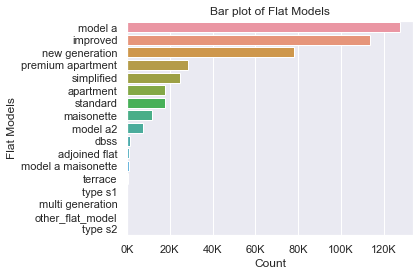

In [2]:
# data['flat_type'].value_counts().sort_values().plot(kind='barh')

sns.set(style="darkgrid")
ax = sns.countplot(y='flat_model', data=data, order=data['flat_model'].value_counts().index)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.title("Bar plot of Flat Models")
plt.ylabel("Flat Models")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("barplot_flatmodels.png")

## Plots of Flat Type

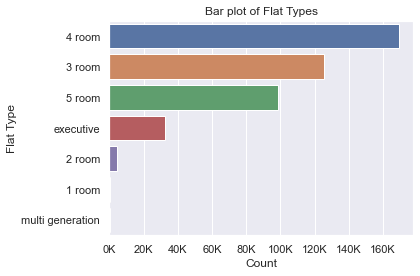

In [3]:
sns.set(style="darkgrid")
ax = sns.countplot(y='flat_type', data=data, order=data['flat_type'].value_counts().index)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.title("Bar plot of Flat Types")
plt.ylabel("Flat Type")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("barplot_flattypes.png")

From the plots above, we can see that 4 room flats take up the largest proportion in our training dataset, with ~40% proportion from the pie chart. 

On the other hand, we can also see that there are some values with very low proportions, such as 2 room, 1 room and multi generation flats.

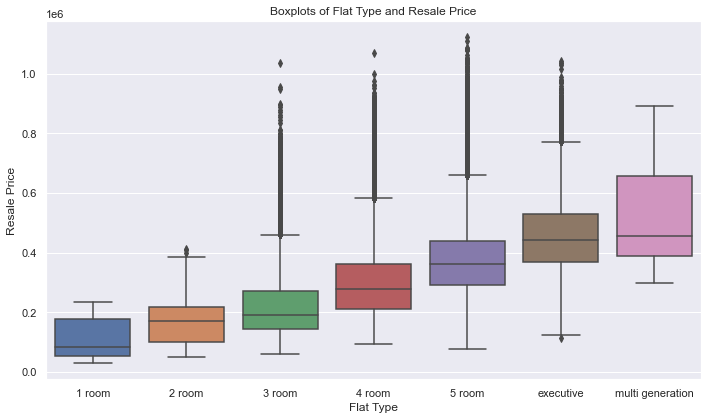

In [4]:
flats_by_flat_type = data.sort_values('resale_price').reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
ax = sns.boxplot(x=flats_by_flat_type['flat_type'], y=flats_by_flat_type['resale_price'], order=data.groupby(by=['flat_type'])['resale_price'].median().index)
plt.xlabel("Flat Type")
plt.ylabel("Resale Price")
plt.title("Boxplots of Flat Type and Resale Price")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("boxplots_flattypes_resaleprice.png")

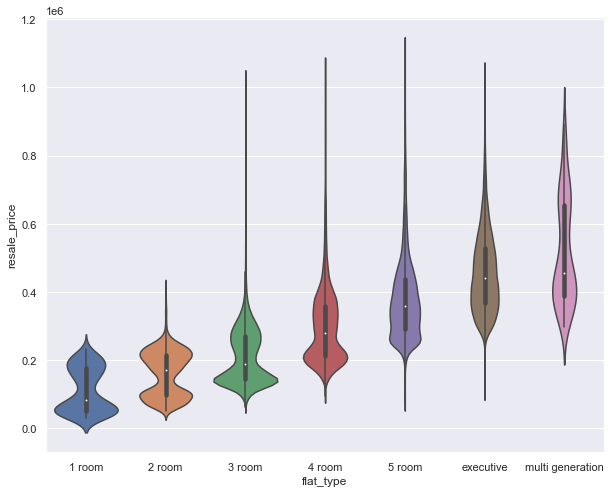

In [5]:
plt.figure(figsize=(10,8))
sns.violinplot(x=flats_by_flat_type['flat_type'], y=flats_by_flat_type['resale_price'], order=data.groupby(by=['flat_type'])['resale_price'].median().index)
plt.show()

There seems to be many extreme outliers in 3 to 5 room and executive flats. Also we can notice the positive correlation between number of rooms in flat_type and resale_price.

## Median prices of flats by planning area

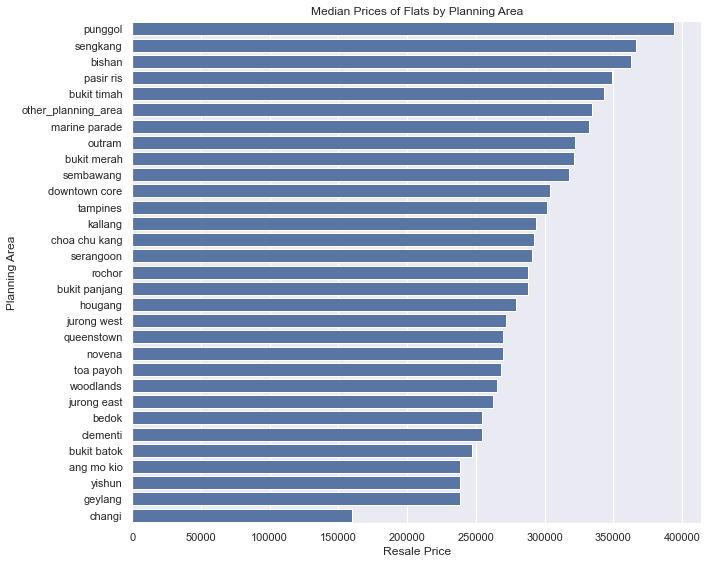

In [6]:
flats_by_planning_area = data.groupby('planning_area').median().sort_values('resale_price').reset_index()

sns.set(style="darkgrid")
sns.color_palette("dark")

plt.figure(figsize=(10,8))
ax = sns.barplot(y='planning_area', x='resale_price', data=flats_by_planning_area, color='b', order=flats_by_planning_area.sort_values('resale_price', ascending=False).planning_area)
plt.xlabel("Resale Price")
plt.ylabel("Planning Area")
plt.title("Median Prices of Flats by Planning Area")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("medianflatprices_byplanningarea.png")

The median prices for flats is the highest for Punggol area while lowest in Changi area.

## Median prices of flats by floor area


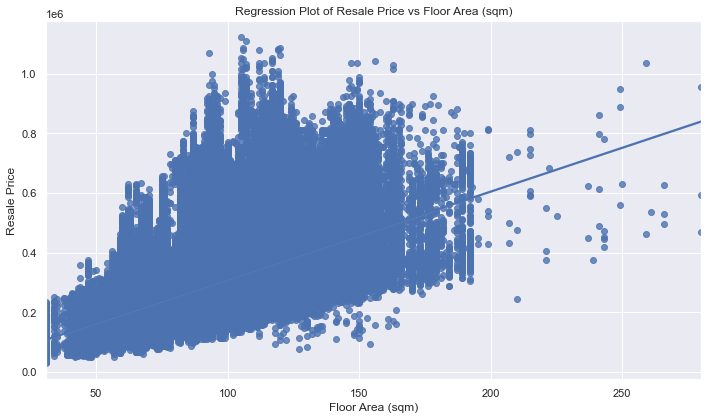

In [7]:
plt.figure(figsize=(10,6))
ax = sns.regplot(x=data['floor_area_sqm'], y=data['resale_price'])

plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price")
plt.title("Regression Plot of Resale Price vs Floor Area (sqm)")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("regressionplot_resalepricevsfloorarea.png")

There looks like a positive correlation between floor area (in sqm) and resale price.

## Median prices of flats by storey

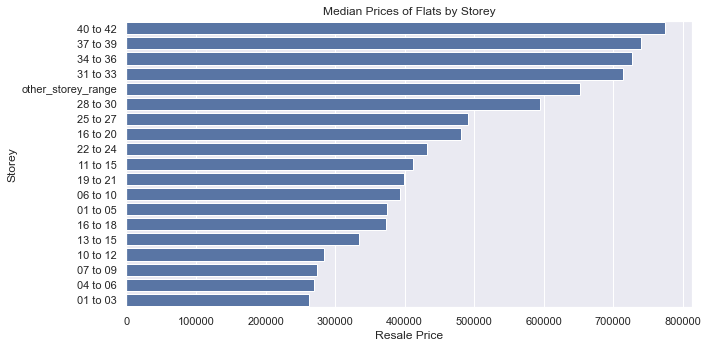

In [8]:
flats_by_storey_range = data.groupby('storey_range').median().sort_values('resale_price').reset_index()

plt.figure(figsize=(10,5))
ax = sns.barplot(y='storey_range', x='resale_price', data=flats_by_storey_range, color='b', order=flats_by_storey_range.sort_values('resale_price', ascending=False).storey_range)

plt.xlabel("Resale Price")
plt.ylabel("Storey")
plt.title("Median Prices of Flats by Storey")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("medianflatprices_bystorey.png")

Storey and resale price seems to be positively correlated (i.e. higher storey range implies higher resale price).

However there are some anomalies in the dataset due to the classifications (we have a storey range 01 to 03 as well as a storey range 01 to 05 in our dataset). This doesn't affect the insight that storey and resale price is positvely correlated.

## Lease Commense Date

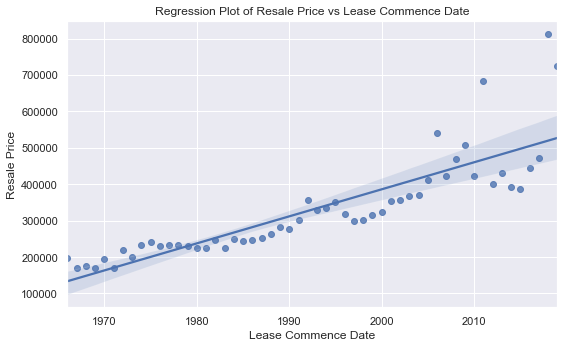

In [9]:
flats_by_lease_commence_date = data.groupby('lease_commence_date').median().sort_values('resale_price').reset_index()

plt.figure(figsize=(8,5))
ax = sns.regplot(x=flats_by_lease_commence_date['lease_commence_date'], y=flats_by_lease_commence_date['resale_price'])
plt.xlabel("Lease Commence Date")
plt.ylabel("Resale Price")
plt.title("Regression Plot of Resale Price vs Lease Commence Date")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("regressionplot_resalepricevsleasecommncedate.png")

There seems to be a slightly positive correlation between lease commense date and resale price.

## Train Stations

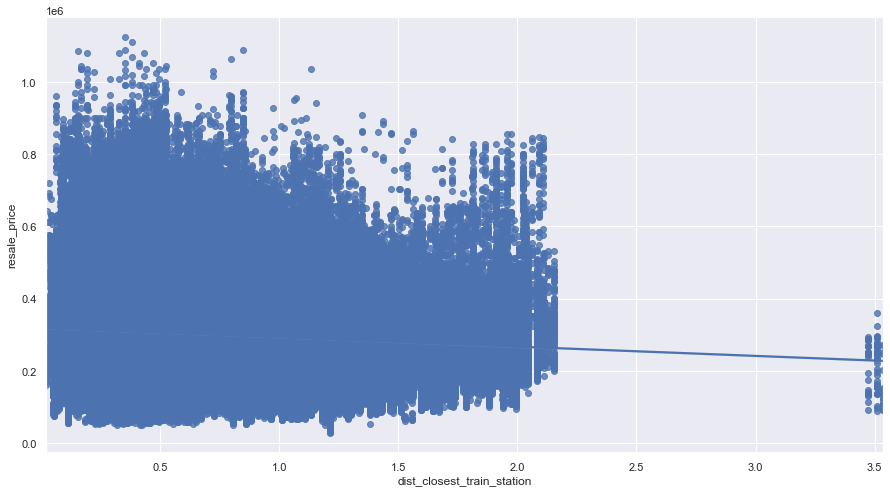

In [10]:
plt.figure(figsize=(15,8))
sns.regplot(x=data['dist_closest_train_station'], y=data['resale_price'])

There seems to be a slight negative correlation between distance to closest train station and resale price which is expected (i.e. the greater the distance to nearest train station, the lower the flat price)

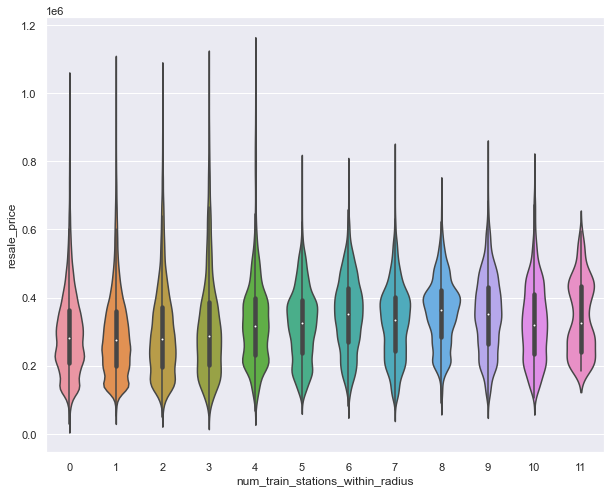

In [11]:
plt.figure(figsize=(10,8))
sns.violinplot(x=flats_by_flat_type['num_train_stations_within_radius'], y=flats_by_flat_type['resale_price'], order=data.groupby(by=['num_train_stations_within_radius'])['resale_price'].median().index)

Slightly positive correlation between number of train stations within 1km radius and resale price. Do note that however this includes LRT stations which may artifically inflate the number since LRT stations are situated close together.

## Shopping Malls

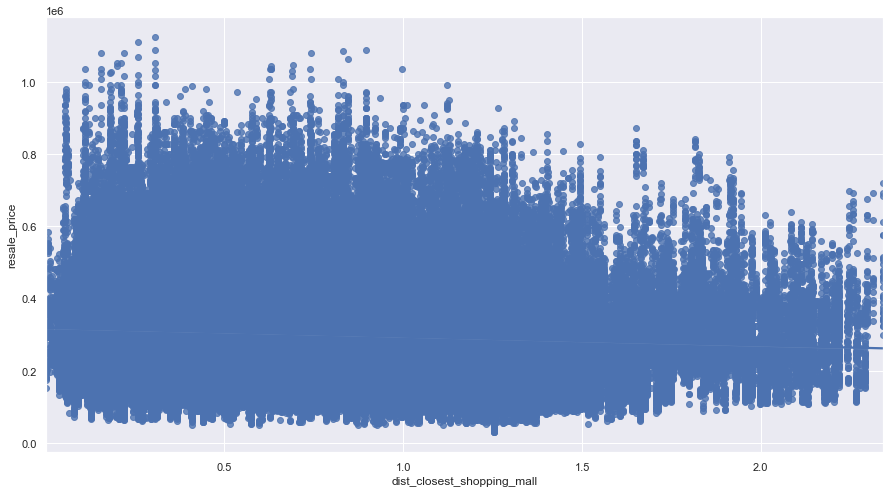

In [12]:
plt.figure(figsize=(15,8))
sns.regplot(x=data['dist_closest_shopping_mall'], y=data['resale_price'])

Doesn't seem to have a correlation between distance to closest shopping mall and resale price

## Primary and secondary schools

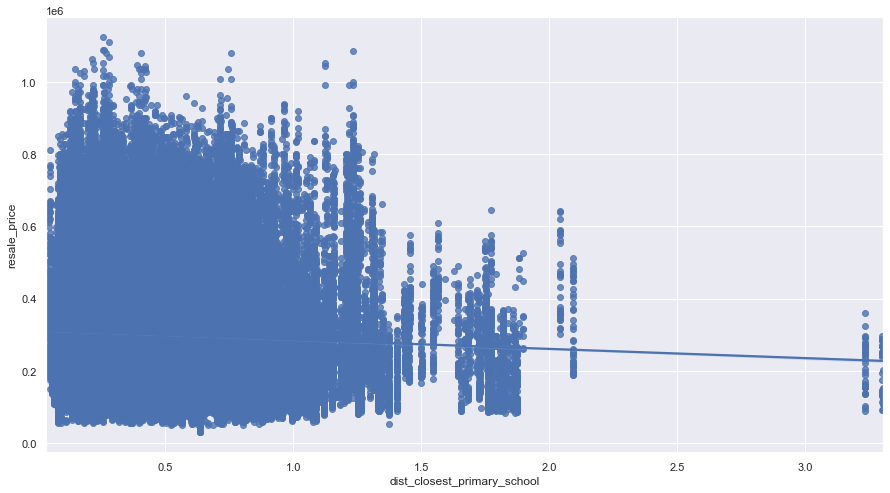

In [13]:
plt.figure(figsize=(15,8))
sns.regplot(x=data['dist_closest_primary_school'], y=data['resale_price'])

There seems to be a slight negative correlation between distance to closest primary school and resale price which is expected (i.e. the greater the distance to nearest primary school, the lower the flat price)

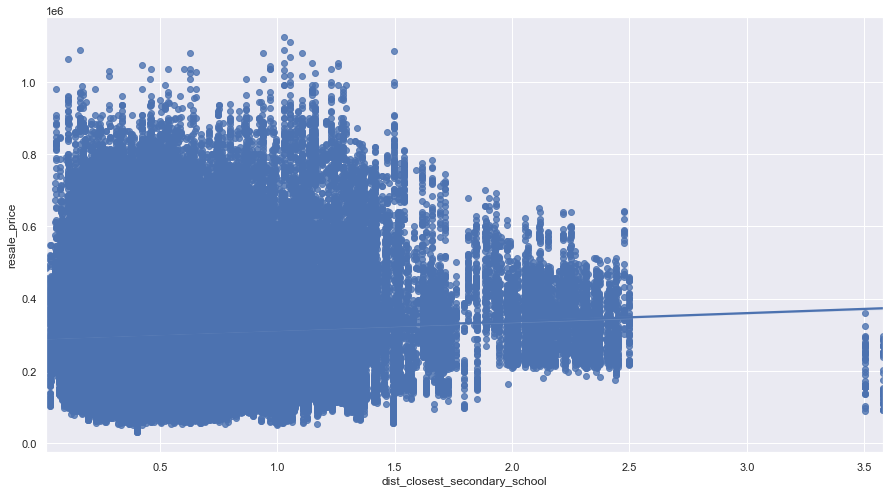

In [14]:
plt.figure(figsize=(15,8))
sns.regplot(x=data['dist_closest_secondary_school'], y=data['resale_price'])

However, there seems to be a slight positive correlation between distance to closest primary school and resale price which is unexpected (i.e. the greater the distance to nearest primary school, the greater the flat price)

## Correlation Heatmap

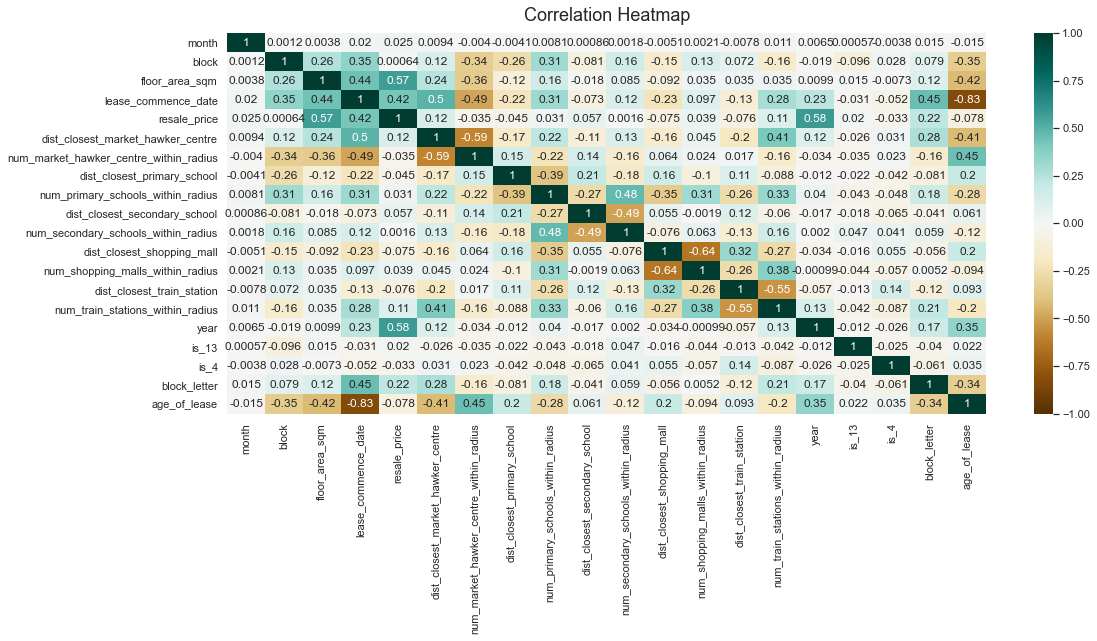

In [15]:
plt.figure(figsize=(17, 7))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

We can see that resale price is quite correlated with floor area, lease commense date and somehow the block letter, which is somewhat intriguing.

There are also some slight correlations between resale price and the distance to hawker center etc.

## Result Plots

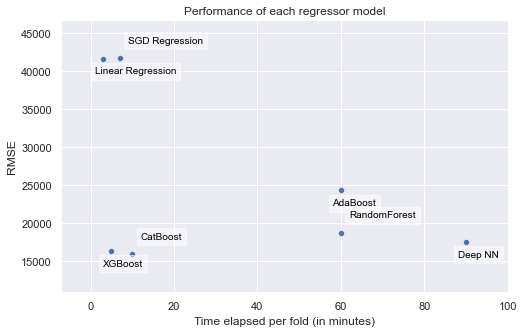

In [25]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
rec=[{'model': 'Linear Regression', 'GD': 11.0, 'G': 3, 'GA': 41662},
  {'model': 'SGD Regression',  'GD': 18.0, 'G': 7, 'GA': 41677},
  {'model': 'AdaBoost',  'GD': 14.0, 'G': 60, 'GA': 24296},
  {'model': 'RandomForest',  'GD': 16.0, 'G': 60, 'GA': 18711},
  {'model': 'XGBoost', 'GD': 15.0, 'G': 5, 'GA': 16366},
  {'model': 'CatBoost',  'GD': 7.0, 'G': 10, 'GA': 15888},
  {'model': 'Deep NN', 'GD': 7.0, 'G': 90, 'GA': 17493}
 ]

df=pd.DataFrame(rec)
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x='G',y='GA')
for i in range(df.shape[0]):
    mul = 1
    if (i%2 == 0):
      mul = -1
    plt.text(x=df.G[i]+2*mul,y=df.GA[i]+2000*mul,s=df.model[i], 
             fontdict=dict(color='black',size=10),
             bbox=dict(facecolor='white',alpha=0.5))
plt.xlim(df.G.min()-10,df.G.max()+10)               
plt.ylim(df.GA.min()-5000,df.GA.max()+5000)             
plt.title("Performance of each regressor model")
plt.xlabel("Time elapsed per fold (in minutes)")                         
plt.ylabel("RMSE")                     
plt.show()

In [17]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train = pd.read_csv("/kaggle/input/asdfasdfasdf/train_cpi_output.csv")
test = pd.read_csv("/kaggle/input/asdfasdfasdf/test_cpi_output.csv")

y = train['resale_price']
X = train.drop(['resale_price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.05)

In [19]:
from catboost import CatBoostRegressor

my_model = CatBoostRegressor(learning_rate=0.1, iterations=5000, random_seed=42, depth=8, verbose=False)
my_model.fit(X_train, y_train)

predictions = my_model.predict(X_test)
print("RMSE : " + str(mean_squared_error(predictions, y_test, squared=False)))

RMSE : 15791.20387054935


In [20]:
# CatBoost feature importances 

my_model.get_feature_importance()

array([2.50483697e+00, 4.08501357e-02, 9.01770550e+00, 7.68278303e-01,
       3.86460353e-01, 3.39610746e-01, 1.09169049e+00, 1.43760291e+00,
       1.09107875e+01, 3.10976877e+01, 5.07189279e+00, 2.53265388e-01,
       9.52863243e-01, 1.84877263e-01, 3.17095701e-01, 3.61039425e-01,
       7.81473539e-01, 1.01609156e+01, 1.95637471e-02, 1.84377239e-02,
       3.27464383e-02, 5.15054595e-04, 5.62968479e-03, 3.68947199e-02,
       0.00000000e+00, 8.36056951e-03, 2.32456501e-01, 7.93676842e+00,
       1.54317860e+00, 1.38162951e+00, 5.21338581e-03, 8.47710395e-01,
       1.48909689e-02, 3.99175562e-01, 1.82381740e-03, 1.15940724e-01,
       5.38879548e-02, 9.98553876e-04, 2.57034751e-02, 7.01928147e-02,
       1.48978669e-03, 9.05629232e-02, 9.08629559e-02, 4.49352546e-02,
       3.52298590e-02, 6.65269763e-03, 9.01440674e-03, 1.40396069e-02,
       1.11046744e-02, 9.57302392e-03, 4.68243550e-02, 2.24512731e-02,
       1.19386439e-01, 5.80729063e-01, 4.45679286e-02, 2.38650052e-01,
      

In [21]:
y = pd.DataFrame({'feature_importance': my_model.get_feature_importance(), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

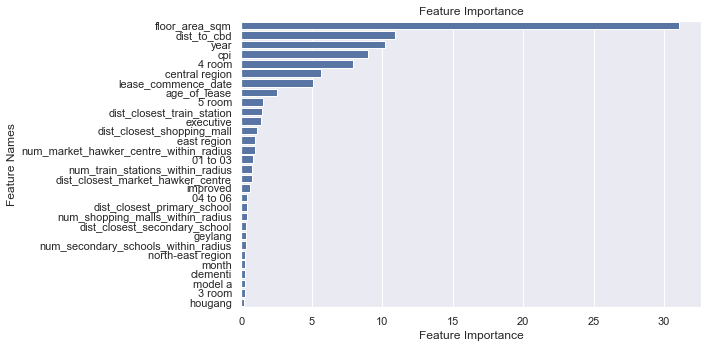

In [22]:
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

plt.figure(figsize=(10,5))
ax = sns.barplot(y='feature_names', x='feature_importance', data=y[0:30], color='b')

plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

ax.get_figure().savefig("feature_importance.png")

In [23]:
from xgboost import XGBRegressor

my_model = XGBRegressor(tree_method='gpu_hist', verbosity=2, n_estimators=1500, max_depth=10, random_state=42, learning_rate=0.05, n_jobs=-1)
my_model.fit(X_train, y_train)

predictions = my_model.predict(X_test)
print("RMSE : " + str(mean_squared_error(predictions, y_test, squared=False)))

RMSE : 16096.57604111648


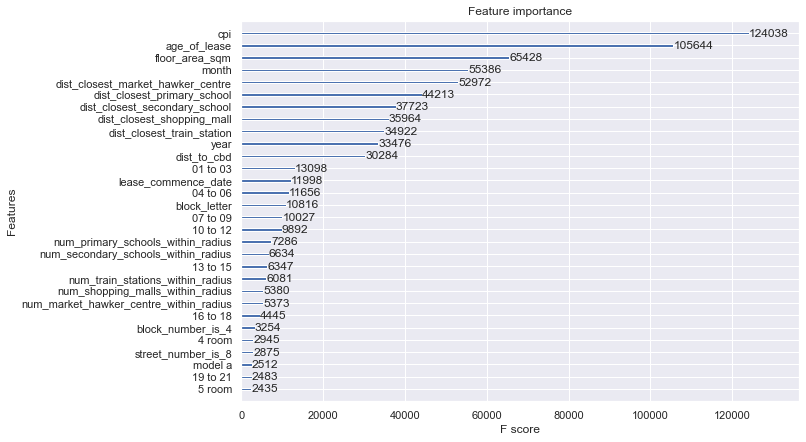

In [24]:
from xgboost import plot_importance
from matplotlib import pyplot

pyplot.figure(figsize=(10, 7))
plot_importance(my_model,ax=pyplot.gca(), max_num_features=30)
pyplot.show()

In [ ]:
test_predictions = my_model.predict(test)
print(len(test_predictions))
test_predictions

In [ ]:
result = pd.DataFrame({'Id': np.arange(len(test_predictions)), 'Predicted': test_predictions})
result.head()

result.to_csv("result.csv", index=False)